# Exploring Auto-Learning for Unsupervised Tokenization Hyper-Parameters based on Compression Factor and Normalized Anti-Entropy - Russian

## Summary
- Self-tuning based on cross-split F1 (CSF1), "Compression factor" (C%) and Normalized Anti-Entropy (~S) and their means and products:
  - provide high correlations with F1
    - CSF1 0.79
    - C% 0.56
    - ~S 0.87
    - mean(C%+~S) 0.67
    - prod(C%*~S) 0.68
  - make it possible to self-tune hyper parameters (with good "recall" yet poorer "precision")
    - **CSFS = 1.0 => F1 = 0.64-0.99 (1 0.64 vs. 7 0.99, good!)**
    - mean(C%+~S) >= 0.26 => F1 = 0.1-1.0 (excellend "recall", poor "precision")
    - prod(C%*~S) >= 0.066 => F1 = 0.37 (does not work at all)
    - C% >= 0.15 => F1 = 0.1 (does not work at all)
    - ~S >= 0.4 => F1 = 0.85 (alone works with poorer "recall" but much better "precision" !!!)

## TODO
- Evaluate on larger test corpus (use train for tuning but test for reference)


In [59]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


In [60]:
path = 'data/corpora/Russian/'
test_df = pd.read_csv(os.path.join(path,'magicdata/zh_en_ru_100/CORPUS_ZH_EN_RU.txt'),delimiter='\t')
test_texts = list(test_df['ru'])
print(len(test_texts))
test_df[['ru']]

100


,ru
0,Как насчет медицинской страховки? В случае ваш...
1,"Для тех, у кого есть страховка, по договору ст..."
2,Необходимо осознать важность наличия страховки.
3,"На самом деле, это явление действительно очень..."
4,Этому поколению родителей действительно необхо...
...,...
95,Ресо предлагает не только страхование автомоби...
96,"Однако при покупке дома, за исключением первон..."
97,Этот вид финансовых вложений имеет определенны...
98,"Если ваша инвестиционная ориентация верна, то ..."


In [61]:
for text in test_texts:
    print(text)

Как насчет медицинской страховки? В случае вашей семьи, её можно оформить и взрослому и ребенку.
Для тех, у кого есть страховка, по договору страхования они получат компенсацию в размере 300 тысяч рублей.
Необходимо осознать важность наличия страховки.
На самом деле, это явление действительно очень распространено, например, для страхования от несчастных случаев, чем больше вы покупаете, тем больше страхуете.
Этому поколению родителей действительно необходимо покупать страховку.
Ну, прямо сейчас действительно желательно купить страховку.
Машину нужно покупать в полном объеме, а дом можно купить в кредит.
Вы можете купить страховку, страховка, конечно же, делится на множество категорий.
Медицинская страховка очень важна.
Эту часть денег платит страховая компания.
Послушайте, я не знаю, слышали ли вы когда-нибудь об этом, это страховка в Сбере.
Покупка дома на самом деле является инвестицией.
Вы когда-нибудь узнавали об обучении в Альфе?
Если он депонирован в банке, каков результат сложны

In [62]:
ref_tokenizer = DelimiterTokenizer()
model_thresholds = [0,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


## First, evaluate Compression Factor and Normalized Anti-Entropy against F1 on reference Tokenization on Magicdata-100 test

75193666


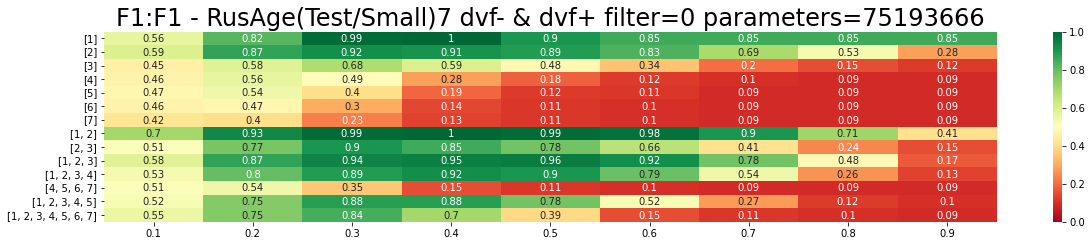

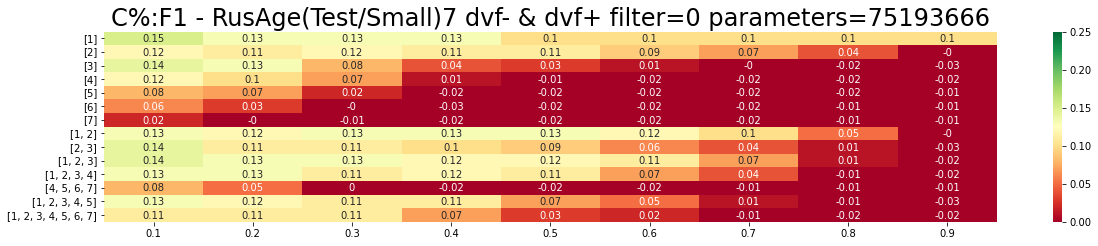

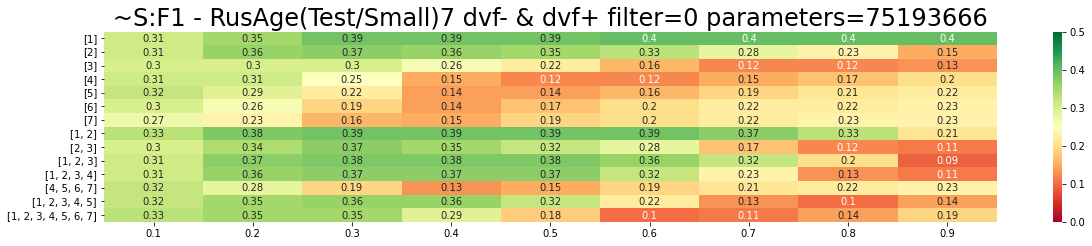

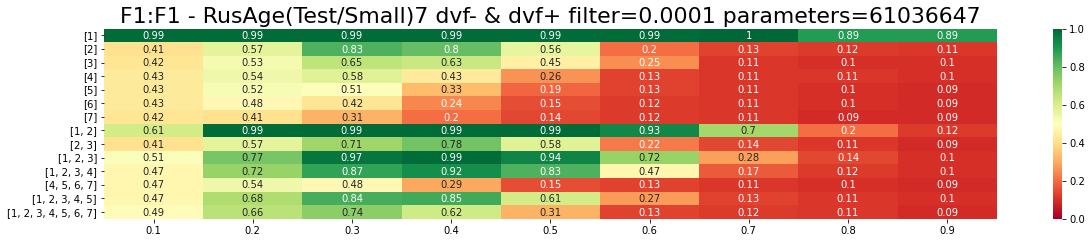

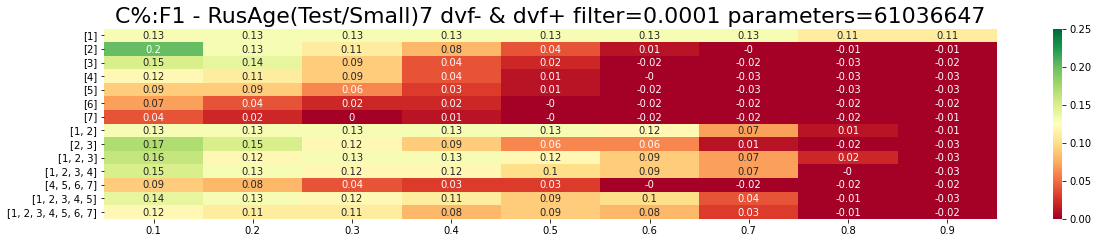

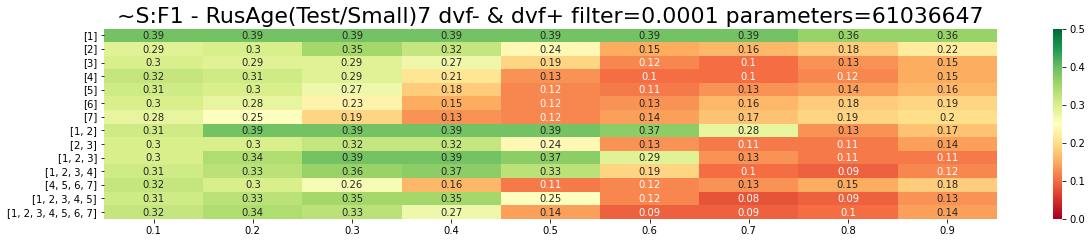

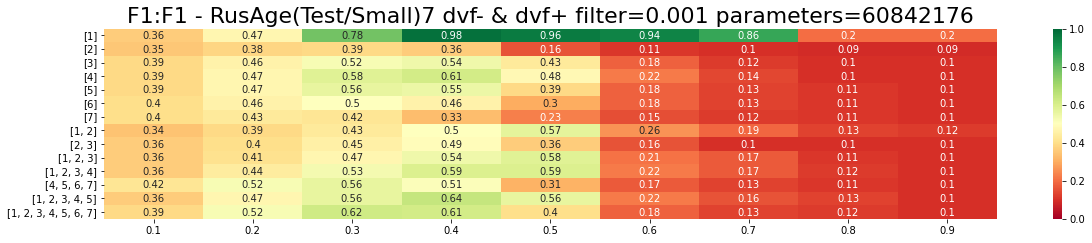

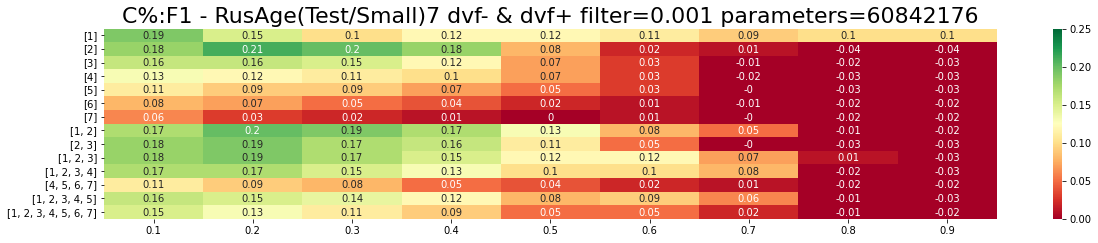

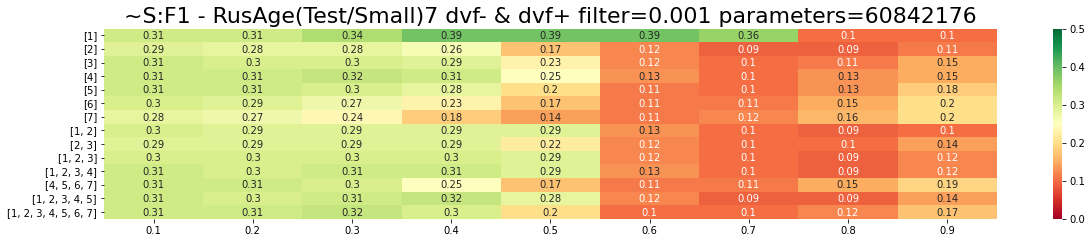

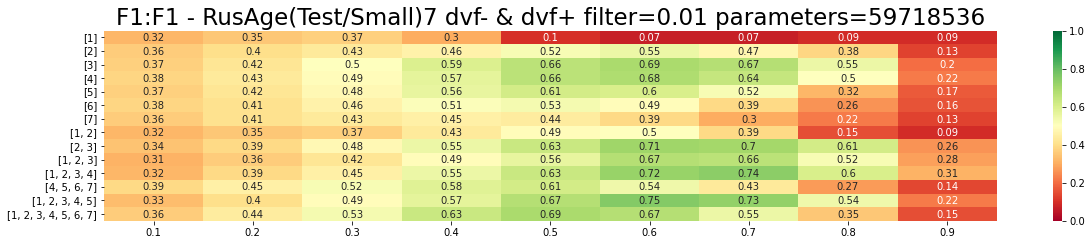

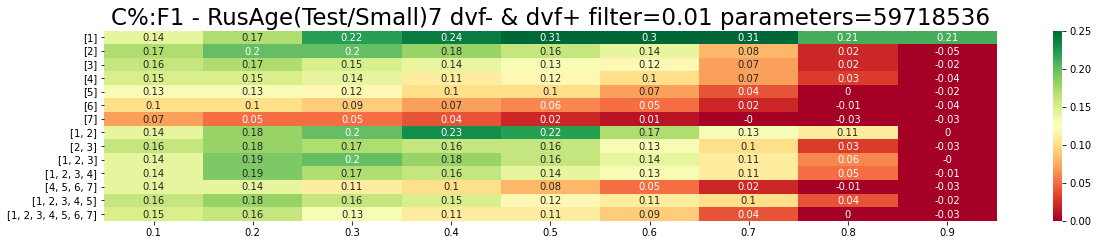

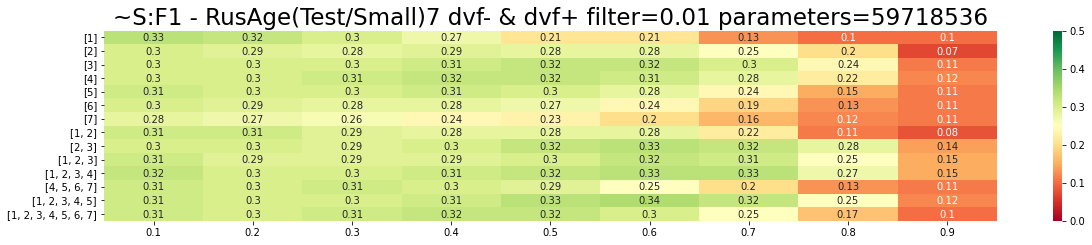

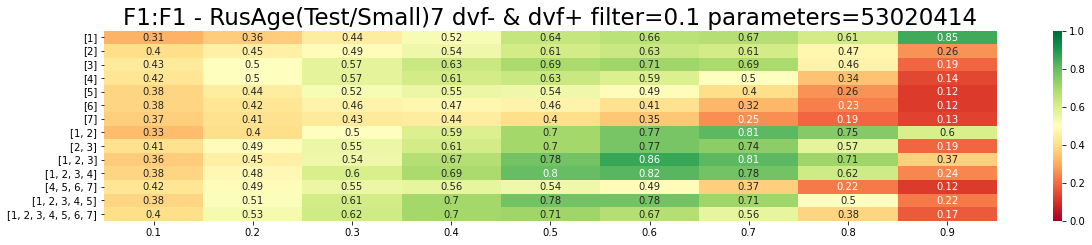

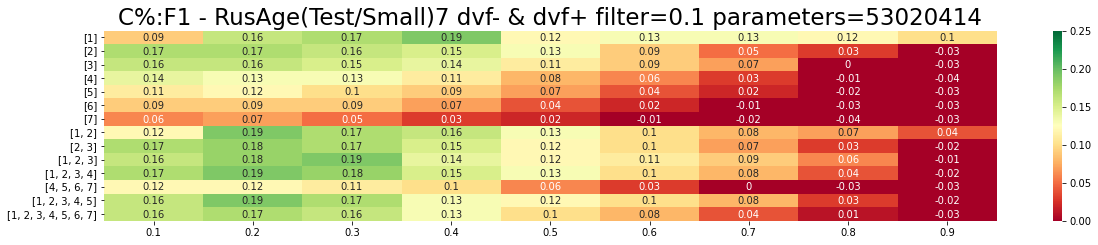

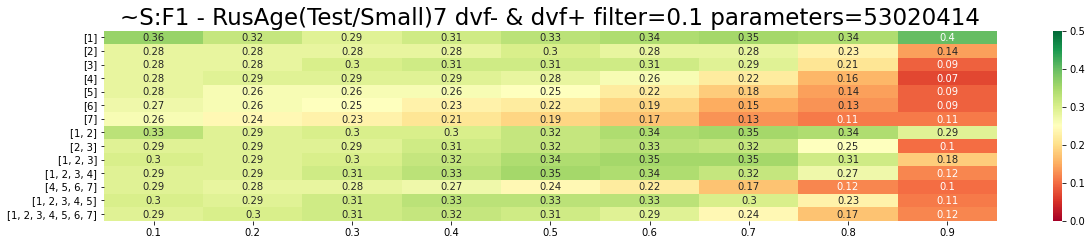

In [8]:
base = FreedomTokenizer(name='data/models/rusage_test_chars_7a',max_n=7,mode='chars',debug=False)
print(base.count_params())
title = 'F1 - RusAge(Test/Small)7 dvf- & dvf+'
metric_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


In [33]:
m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
m_df['C%H~S'] = (2*m_df['C%'] * m_df['~S'])/(m_df['C%'] + m_df['~S']) # Harmonic mean
print('F1 X C%',m_df['F1'].corr(m_df['C%']))
print('F1 X ~S',m_df['F1'].corr(m_df['~S']))
print('F1 X C%+~S',m_df['F1'].corr(m_df['C%+~S']))
print('F1 X C%*~S',m_df['F1'].corr(m_df['C%*~S']))
print('F1 X C%H~S',m_df['F1'].corr(m_df['C%H~S']))
m_df


F1 X C% 0.5597551126127919
F1 X SH 0.872372874684484
F1 X C%+~S 0.7886604594403859
F1 X C%*~S 0.6688642211353917
F1 X C%H~S 0.6835681131842486


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S,C%H~S
0,0.0,[1],0.1,0.56,0.15,0.31,0.230,0.0465,0.202174
1,0.0,[1],0.2,0.82,0.13,0.35,0.240,0.0455,0.189583
2,0.0,[1],0.3,0.99,0.13,0.39,0.260,0.0507,0.195000
3,0.0,[1],0.4,1.00,0.13,0.39,0.260,0.0507,0.195000
4,0.0,[1],0.5,0.90,0.10,0.39,0.245,0.0390,0.159184
...,...,...,...,...,...,...,...,...,...
625,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.5,0.71,0.10,0.31,0.205,0.0310,0.151220
626,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.6,0.67,0.08,0.29,0.185,0.0232,0.125405
627,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.7,0.56,0.04,0.24,0.140,0.0096,0.068571
628,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.8,0.38,0.01,0.17,0.090,0.0017,0.018889


In [20]:
m_df.sort_values(by=['C%','F1'],ascending=False)[:5]
# F1 = 0.10 - Too bad

,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
382,0.01,[1],0.5,0.10,0.31,0.21,0.260,0.0651
384,0.01,[1],0.7,0.07,0.31,0.13,0.220,0.0403
383,0.01,[1],0.6,0.07,0.30,0.21,0.255,0.0630
381,0.01,[1],0.4,0.30,0.24,0.27,0.255,0.0648
444,0.01,"[1, 2]",0.4,0.43,0.23,0.28,0.255,0.0644


In [30]:
m_df.sort_values(by=['~S','F1'],ascending=False)[:30]
# F1 = 0.85 <= 0.40 - Precision is good but recall is not 

,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
5,0.0000,[1],0.6,0.85,0.10,0.40,0.250,0.0400
6,0.0000,[1],0.7,0.85,0.10,0.40,0.250,0.0400
7,0.0000,[1],0.8,0.85,0.10,0.40,0.250,0.0400
8,0.0000,[1],0.9,0.85,0.10,0.40,0.250,0.0400
512,0.1000,[1],0.9,0.85,0.10,0.40,0.250,0.0400
3,0.0000,[1],0.4,1.00,0.13,0.39,0.260,0.0507
66,0.0000,"[1, 2]",0.4,1.00,0.13,0.39,0.260,0.0507
132,0.0001,[1],0.7,1.00,0.13,0.39,0.260,0.0507
2,0.0000,[1],0.3,0.99,0.13,0.39,0.260,0.0507
65,0.0000,"[1, 2]",0.3,0.99,0.13,0.39,0.260,0.0507


In [32]:
m_df.sort_values(by=['C%+~S','F1'],ascending=False)[:25]
# F1 = 0.1-1.0 <= 0.26 - The best, but not accurate (decent recall, poor precision)

,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
3,0.0000,[1],0.4,1.00,0.13,0.39,0.260,0.0507
66,0.0000,"[1, 2]",0.4,1.00,0.13,0.39,0.260,0.0507
132,0.0001,[1],0.7,1.00,0.13,0.39,0.260,0.0507
2,0.0000,[1],0.3,0.99,0.13,0.39,0.260,0.0507
65,0.0000,"[1, 2]",0.3,0.99,0.13,0.39,0.260,0.0507
67,0.0000,"[1, 2]",0.5,0.99,0.13,0.39,0.260,0.0507
126,0.0001,[1],0.1,0.99,0.13,0.39,0.260,0.0507
127,0.0001,[1],0.2,0.99,0.13,0.39,0.260,0.0507
128,0.0001,[1],0.3,0.99,0.13,0.39,0.260,0.0507
129,0.0001,[1],0.4,0.99,0.13,0.39,0.260,0.0507


In [31]:
m_df.sort_values(by=['C%*~S','F1'],ascending=False)[:5]
# F1 = 0.37 - The worst

,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
380,0.01,[1],0.3,0.37,0.22,0.30,0.260,0.0660
382,0.01,[1],0.5,0.10,0.31,0.21,0.260,0.0651
381,0.01,[1],0.4,0.30,0.24,0.27,0.255,0.0648
444,0.01,"[1, 2]",0.4,0.43,0.23,0.28,0.255,0.0644
383,0.01,[1],0.6,0.07,0.30,0.21,0.255,0.0630


## Next, evaluate mutual/cross F1 between two models of the split data set against F1 on reference Tokenization on Magicdata-100 test


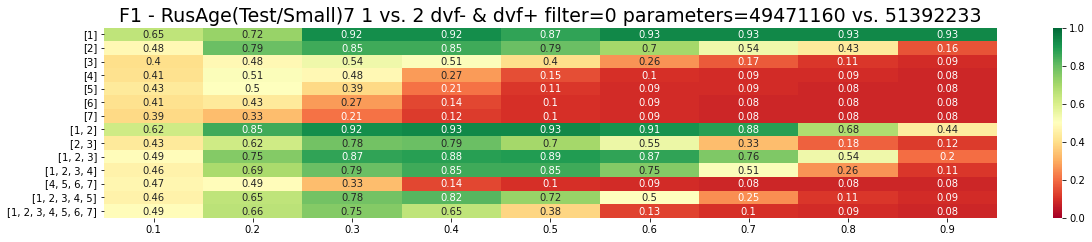

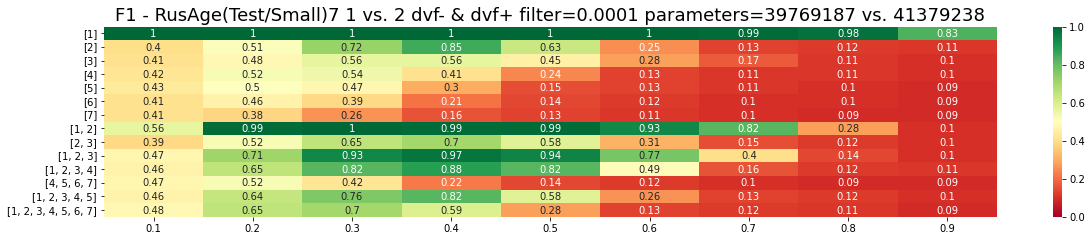

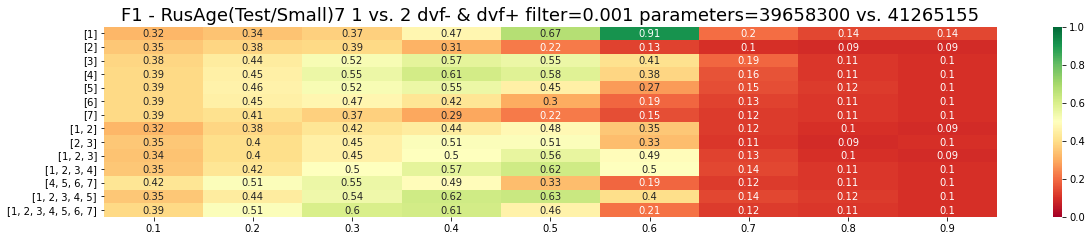

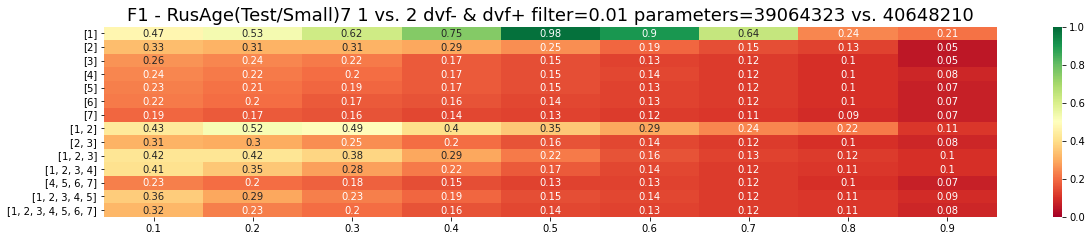

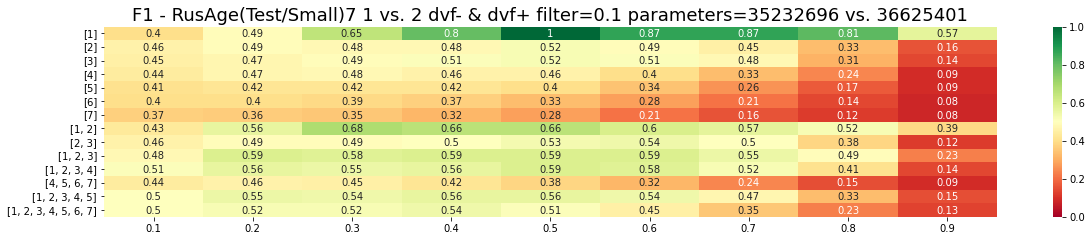

In [36]:
base1 = FreedomTokenizer(name='data/models/rusage_test1_chars_7',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/rusage_test2_chars_7',max_n=7,mode='chars',debug=False)
title = 'F1 - RusAge(Test/Small)7 1 vs. 2 dvf- & dvf+'
cross_f_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_texts,
        FreedomBasedTokenizer(base1,'dvf-','dvf+'),
        FreedomBasedTokenizer(base2,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross_f_list.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [37]:
m_cross_df = pd.DataFrame(cross_f_list,columns=['MT','NG','TT','F1-cross'])
print(m_df['F1'].corr(m_cross_df['F1-cross']))
m_df['F1-cross'] = m_cross_df['F1-cross']
m_df


0.7945460267513358


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S,C%H~S,F1-cross
0,0.0,[1],0.1,0.56,0.15,0.31,0.230,0.0465,0.202174,0.65
1,0.0,[1],0.2,0.82,0.13,0.35,0.240,0.0455,0.189583,0.72
2,0.0,[1],0.3,0.99,0.13,0.39,0.260,0.0507,0.195000,0.92
3,0.0,[1],0.4,1.00,0.13,0.39,0.260,0.0507,0.195000,0.92
4,0.0,[1],0.5,0.90,0.10,0.39,0.245,0.0390,0.159184,0.87
...,...,...,...,...,...,...,...,...,...,...
625,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.5,0.71,0.10,0.31,0.205,0.0310,0.151220,0.51
626,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.6,0.67,0.08,0.29,0.185,0.0232,0.125405,0.45
627,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.7,0.56,0.04,0.24,0.140,0.0096,0.068571,0.35
628,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.8,0.38,0.01,0.17,0.090,0.0017,0.018889,0.23


In [40]:
m_df.sort_values(by=['F1-cross','F1'],ascending=False)[:20]


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S,C%H~S,F1-cross
126,0.0001,[1],0.1,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
127,0.0001,[1],0.2,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
128,0.0001,[1],0.3,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
129,0.0001,[1],0.4,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
130,0.0001,[1],0.5,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
131,0.0001,[1],0.6,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
191,0.0001,"[1, 2]",0.3,0.99,0.13,0.39,0.260,0.0507,0.195000,1.00
508,0.1000,[1],0.5,0.64,0.12,0.33,0.225,0.0396,0.176000,1.00
132,0.0001,[1],0.7,1.00,0.13,0.39,0.260,0.0507,0.195000,0.99
190,0.0001,"[1, 2]",0.2,0.99,0.13,0.39,0.260,0.0507,0.195000,0.99


## Further, repeat the same experiment using self-tuning metrics (CFF1, C% and ~S) based on 1K subset of the train set itself, to compare against F1 of test set in the same space of Hyper-Parameters

In [ ]:
#TODO test the same on larger test corpus (subset of train!?)

In [63]:
from os import listdir
from os.path import isfile, join

def load_lines(folder_path):
    all_lines = []
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    cnt = 0
    for file in onlyfiles:
        with open(join(folder_path, file),errors='ignore') as f:
            lines = f.readlines()
            all_lines.extend(lines)
    return all_lines


In [64]:
lines = load_lines('../../nlp/corpora/Russian/rusage/archive/test')
print(len(lines))


1047341


In [65]:
test_texts = [l.strip() for l in lines if not len(l.strip()) == 0 or '#' in l][0::487]
print(len(test_texts))


1001


75193666


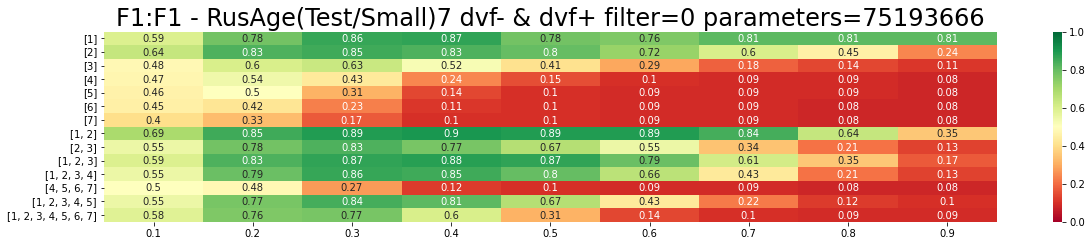

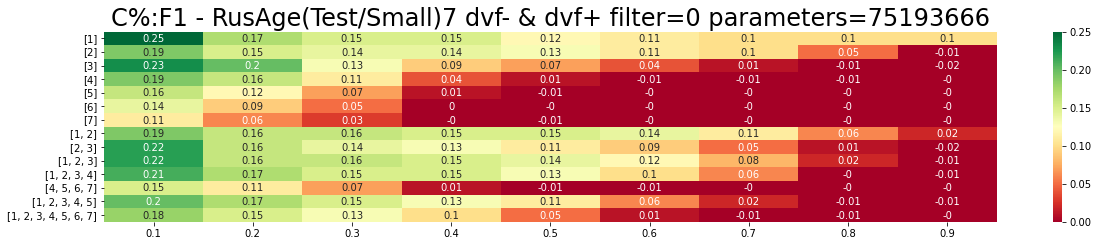

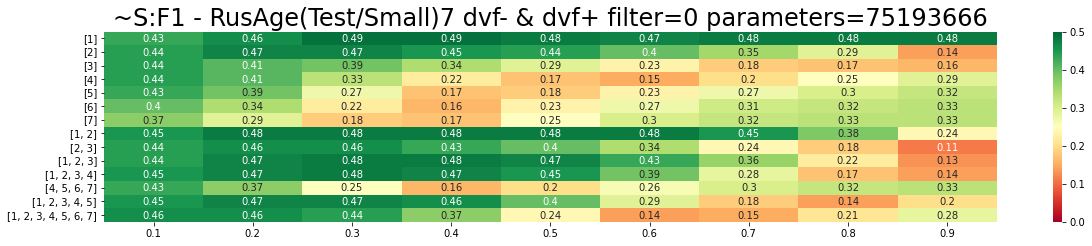

In [ ]:
base = FreedomTokenizer(name='data/models/rusage_test_chars_7a',max_n=7,mode='chars',debug=False)
print(base.count_params())
title = 'F1 - RusAge(Test/Small)7 dvf- & dvf+'
metric_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


In [ ]:
base1 = FreedomTokenizer(name='data/models/rusage_test1_chars_7',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/rusage_test2_chars_7',max_n=7,mode='chars',debug=False)
title = 'F1 - RusAge(Test/Small)7 1 vs. 2 dvf- & dvf+'
cross_f_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_texts,
        FreedomBasedTokenizer(base1,'dvf-','dvf+'),
        FreedomBasedTokenizer(base2,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross_f_list.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [ ]:
#TODO explore and conclude

In [ ]:
#TODO evaluate of 10 times larger train set as a test